# Neural citation network for local citation recommendation

In [1]:
import torch
from torchtext.data import BucketIterator
from ncn.evaluation import Evaluator
from ncn.data import get_datasets
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

In [18]:
path_to_weights = "/home/timo/Downloads/models/NCN_7_19_15.pt"
path_to_data = "/home/timo/DataSets/KD_arxiv_CS/arxiv_data.csv"

In [3]:
data = get_datasets(path_to_data)

INFO:neural_citation.data:Getting fields...
INFO:neural_citation.data:Loading dataset...
INFO:neural_citation.data:Building vocab...


In [4]:
def display_dict(d):
    """Display a dict nice and pretty."""
    for key, value in d.items():
        print(f"Citation rank {key}|\t {value}")

In [5]:
def display_attention(title, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap="plasma")
   
    ax.tick_params(labelsize=15)
    xlabels = ["Context TDNN 1 (f=4)", "Context TDNN 2 (f=4)", "Context TDNN 3 (f=5)",
              "Citing TDNN 1 (f=1)", "Citing TDNN 2 (f=2)",
              "Cited TDNN 1 (f=1)", "Cited TDNN 2 (f=2)"
              ]
    ax.set_xticklabels([''] + xlabels, 
                       rotation=90)
    # have tokenized title here
    ax.set_yticklabels([''] + title)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(cax)

# ![stats_icon](assets/Stats_icon.png) Data: Basic statistics
1. Removed 8260 triplets of paper data due to empty/missing files.  
2. Removed 1 data sample throwing regex error.  
3. Removed 161670 context samples where information was missing/could not be parsed from files.   
* This leaves __502353 context - citation pairs__ with full information.
* __Context vocabulary__ size after processing: __72046__.  
* __Title vocabulary__ size after processing: __43208__.  
* Number of __citing authors__: __28200__.  
* Number of __cited authors__: __169236__. 

![Context and title length distributions](assets/title_context_distribution.jpg)

* Training examples (80%): __401882__. 
* Validation examples (10%): __50236__. 
* Test examples (10%): __50235__. 

# ![field_icon](assets/Field_icon.png) Data preprocessing with torchtext Fields 
![Field](assets/Field_viz.JPG)

In [6]:
context = "Neural networks are really cool, especially if they are convolutional."
authors = "Chuck Norris, Bruce Lee"

## Tokenization and Preprocessing
* Tokenization
* Stopword removal
* Lowercasing
* Cutoff

In [7]:
tokenized = data.cntxt.tokenize(context)

In [8]:
tokenized

['Neural',
 'network',
 'be',
 'really',
 'cool',
 'especially',
 'if',
 'they',
 'be',
 'convolutional']

## Numericalization
* Matching words to vocabulary indices

In [9]:
data.cntxt.numericalize([tokenized])

tensor([[   0,    3,    0,    0, 4632,  765,    0,    0,    0,  405]])

## Batch processing
* Pad batches on the fly

In [10]:
examples = [example.context for example in data.train.examples[:30]]

In [11]:
examples[4]

['recently',
 'concept',
 'energy',
 'share',
 'bss',
 'emerge',
 'step',
 'self',
 'reliance',
 'cellular',
 'network',
 'term',
 'energy']

In [12]:
tensorized = data.cntxt.numericalize(data.cntxt.pad(examples))

In [13]:
print(f"Batch data type: {tensorized.type()}")
print(f"Batch shape: {tensorized.shape}")
print(tensorized[:2, :])

Batch data type: torch.LongTensor
Batch shape: torch.Size([30, 29])
tensor([[  836,     9,    84,  3509,    44,    33,    58,   626,    51,   280,
          1057,     7,   667,  1628,   547,   353,   101,   150,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1],
        [  390,   169,    48, 18512,   762,  2482,   200, 27258,   579,    45,
             0, 14740,   185,    85,   220,  1176,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1]])


# ![bucketing_icon](assets/Bucketing_icon.png) Bucketing: What it is and why do we need it?
![Bucketing](assets/Bucketing_viz.JPG)

In [14]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((data.train, data.valid, data.test), 
                                                                          batch_size = 32,
                                                                          sort_within_batch = True,
                                                                          sort_key = lambda x : len(x.title_cited))

In [15]:
batch = next(iter(train_iterator))

## Bucketed batch
* Sequences in a batch have similar length.
* Drastically reduces training time.  

In [16]:
batch.title_cited.permute(1,0)[:5]

tensor([[   2,   57,  176,    4,  116, 2823, 1027, 1176,    3],
        [   2,  108,   27, 1495,  203,  126,   75,   83,    3],
        [   2,  438,   24,  428,  421,    4,    6,  255,    3],
        [   2,  471,    8,  395,  463,   22, 3480,  593,    3],
        [   2,  187, 1446,  143,  187,    4, 4905, 2279,    3]])

# ![demo_icon](assets/Demo_icon.png) Demo

In [19]:
evaluator = Evaluator(path_to_weights, data, evaluate=False, show_attention=True)

INFO:neural_citation.evaluation:INITIALIZING NEURAL CITATION NETWORK WITH AUTHORS = True
Running on: cpu
Number of model parameters: 23,844,532
Encoders: # Filters = 128, Context filter length = [4, 4, 5],  Context filter length = [1, 2]
Embeddings: Dimension = 128, Pad index = 1, Context vocab = 30002, Author vocab = 30002, Title vocab = 30004
Decoder: # GRU cells = 2, Hidden size = 128
Parameters: Dropout = 0.2, Show attention = True
-------------------------------------------------
INFO:neural_citation.evaluation:Creating corpus in eval=False mode.
INFO:neural_citation.evaluation:Number of samples in BM25 corpus: 1205646


In [20]:
recomms, a = evaluator.recommend(context, authors)

In [24]:
display_dict(recomms)

Citation rank 0|	 Imagenet classification with   deep convolutional neural networks
Citation rank 1|	 Fully convolutional networks for   semantic segmentation
Citation rank 2|	 Caffe: Convolutional architecture for fast   feature embedding
Citation rank 3|	 Very deep convolutional networks for   large-scale image recognition
Citation rank 4|	 Visualizing and understanding convolutional   networks


# ![attention_icon](assets/Attention_icon.png) But what about attention?

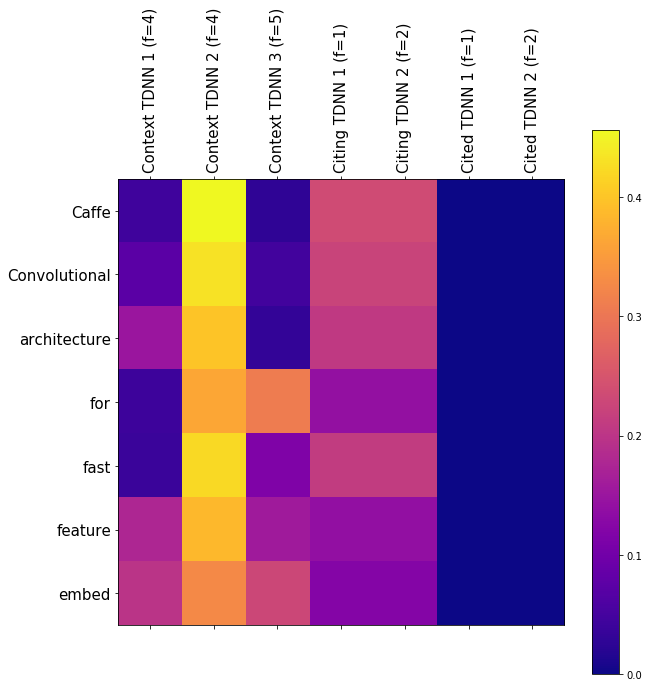

In [21]:
rec = 2
seq = data.cntxt.tokenize(recomms[rec])
display_attention(seq, a[1:len(seq)+1, rec, :])

# ![docs_icon](assets/Docs_icon.png) Documentation
![Docs](assets/Documentation.png)

# Paremeters
![Parameters](assets/lecun.PNG)